# Amazon Fine Food Reviews Analysis using Logistic Regression.

Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

#### Basic information about the downloaded dataset<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

#### Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Our main objective for this analysis is to train a model which can seperate the postive and negative reviews.
In this problem we will apply classification techniques called Logistic Regression to get an idea if the data can be seperated based on its polarity, i.e. if the review is positive or negative. By looking at the Score column we can make out that the review is positive or not. But we don't need to implement any ML here. A simple if-else condition will make us do this. So for this problem, we will put our focus on to the Review text. The text is the most important feature here if you may ask. Based on the review text we will build a prediction model and determine if a future review is positive or negative.

#### While pre-processing the original dataset we have taken into consideration the following points.

1. We will classify a review to be positive if and only if the corresponding Score for the given review is 4 or 5.
2. We will classify a review to be negative if and only if the corresponding Score for the given review is 1 or 2.
3. We will ignore the reviews for the time being which has a Score rating of 3. Because 3 can be thought of as a neutral review. It's neither negative nor positive.
4. We will remove the duplicate entries from the dataset. 
5. We will train our final mdel using four featurizations -> bag of words model, tf-idf model, average word-to-vec model and tf-idf weighted word-to-vec model.
6. So at end of the training the model will be trained on the above four featurizations to determine if a given review is positive or negative (Determining the sentiment polarity of the Amazon reviews)

## [1.0] Importing Libraries

In [4]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
import math
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
#from gensim.models import Word2Vec
#from gensim.models import KeyedVectors
import pickle
from tqdm import tqdm
import os
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_curve, auc
from sklearn.calibration import CalibratedClassifierCV
from datetime import datetime as dt

## [1.1] Loading the data

In [5]:
connection_sqlite3 = sqlite3.connect('database.sqlite')
filtered_data = pd.read_sql_query("""select * from reviews where score!=3""", connection_sqlite3)

In [6]:
filtered_data.shape

(525814, 10)

In [7]:
filtered_data.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...


In [8]:
filtered_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525814 entries, 0 to 525813
Data columns (total 10 columns):
Id                        525814 non-null int64
ProductId                 525814 non-null object
UserId                    525814 non-null object
ProfileName               525814 non-null object
HelpfulnessNumerator      525814 non-null int64
HelpfulnessDenominator    525814 non-null int64
Score                     525814 non-null int64
Time                      525814 non-null int64
Summary                   525814 non-null object
Text                      525814 non-null object
dtypes: int64(5), object(5)
memory usage: 40.1+ MB


## [1.2] - Check for Balancing, Duplicates and NULLs

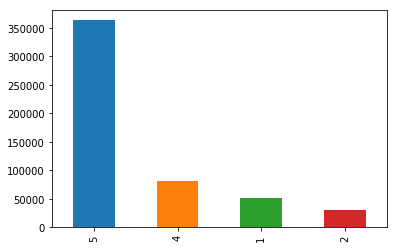

In [9]:
filtered_data['Score'].value_counts().plot.bar()

In [10]:
dup_boolean = filtered_data.duplicated(['ProductId','UserId','Time'])
duplicates_count=sum(dup_boolean)
print('There are {} duplicates in the dataset'.format(duplicates_count))

There are 3685 duplicates in the dataset


In [11]:
deduplicated_data=filtered_data.drop_duplicates(subset=['ProductId','UserId','Time'],keep='first',inplace=False)
print('Duplicates removed, no. of records in D afterwards :{}'.format(deduplicated_data.shape[0]))

Duplicates removed, no. of records in D afterwards :522129


In [12]:
print('No. of Null values in the dataset :{}'.format(sum(deduplicated_data.isnull().any())))

No. of Null values in the dataset :0


## [1.3]- Illogical records removal, Unwanted Columns removal, Target Columns Addition, Outliers removal

In [13]:
deduplicated_data[deduplicated_data['HelpfulnessNumerator']>deduplicated_data['HelpfulnessDenominator']].count()

Id                        2
ProductId                 2
UserId                    2
ProfileName               2
HelpfulnessNumerator      2
HelpfulnessDenominator    2
Score                     2
Time                      2
Summary                   2
Text                      2
dtype: int64

In [14]:
deduplicated_data[deduplicated_data['HelpfulnessNumerator']>deduplicated_data['HelpfulnessDenominator']].head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
41159,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...
59301,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...


In [16]:
filtered_data1=deduplicated_data[deduplicated_data['HelpfulnessNumerator']<=deduplicated_data['HelpfulnessDenominator']]
print('Illogical records removed, no. of records in D afterwards :{}'.format(filtered_data1.shape[0]))

Illogical records removed, no. of records in D afterwards :522127


In [17]:
filtered_data2=filtered_data1[['Id','ProductId','UserId','Score','Summary','Text']]
filtered_data2.head(1)

,Id,ProductId,UserId,Score,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,5,Good Quality Dog Food,I have bought several of the Vitality canned d...


In [18]:
filtered_data2['SentimentPolarity']=filtered_data2['Score'].apply(lambda x:'Positive' if x>3 else 'Negative')
filtered_data2.head(2)

,Id,ProductId,UserId,Score,Summary,Text,SentimentPolarity
0,1,B001E4KFG0,A3SGXH7AUHU8GW,5,Good Quality Dog Food,I have bought several of the Vitality canned d...,Positive
1,2,B00813GRG4,A1D87F6ZCVE5NK,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Negative


In [19]:
filtered_data2['Class_Labels']=filtered_data2['SentimentPolarity'].apply(lambda x: 1 if x=='Positive' else 0)
filtered_data2.head(2)

,Id,ProductId,UserId,Score,Summary,Text,SentimentPolarity,Class_Labels
0,1,B001E4KFG0,A3SGXH7AUHU8GW,5,Good Quality Dog Food,I have bought several of the Vitality canned d...,Positive,1
1,2,B00813GRG4,A1D87F6ZCVE5NK,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Negative,0


In [20]:
print('Note: This is a classification problem based on raw text, no obvious outlier in this case. The objective is not to find what score a user would give to a product, that is the use case of recommender systems, but the objective is to infer wheather a review is having a postive sentiment or a negative sentiment based on review text')

Note: This is a classification problem based on raw text, no obvious outlier in this case. The objective is not to find what score a user would give to a product, that is the use case of recommender systems, but the objective is to infer wheather a review is having a postive sentiment or a negative sentiment based on review text


## [2.0] - Preprocessing the text (HUP2$MLSS)

### [2.1] Preprocessing functions creation

In [21]:
def removeHtml(line):
    pattern=re.compile('<.*?>')
    return re.sub(pattern,'',line)

removeHtml('world <is a > good </place>')

'world  good '

In [22]:
def removeUrl(line):
    return re.sub('http\S+','',line,flags=re.IGNORECASE) #re.IGNORECASE doesn't work with precompiled patterns like used in removeHtml function

removeUrl('HTTPs://google.com is URL for google')

' is URL for google'

In [23]:
#https://stackoverflow.com/questions/37012948/regex-to-match-an-entire-word-that-contains-repeated-character
#Remove words like 'zzzzzzzzzzzzzzzzzzzzzzz', 'testtting', 'grrrrrrreeeettttt' etc. Preserves words like 'looks', 'goods', 'soon' etc. We will remove all such words which has three consecutive repeating characters.
def removePatterns(sentence): 
    cleaned_text  = re.sub("\\s*\\b(?=\\w*(\\w)\\1{2,})\\w*\\b",' ',sentence)
    return (cleaned_text)

removePatterns('It is a greeeaaattt product')

'It is a  product'

In [24]:
def decontracted(x):
    x = str(x).lower()
    x = x.replace(",000,000", " m").replace(",000", " k").replace("′", "'").replace("’", "'")\
                           .replace("won't", " will not").replace("cannot", " can not").replace("can't", " can not")\
                           .replace("n't", " not").replace("what's", " what is").replace("it's", " it is")\
                           .replace("'ve", " have").replace("'m", " am").replace("'re", " are")\
                           .replace("he's", " he is").replace("she's", " she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will").replace("how's"," how has").replace("y'all"," you all")\
                           .replace("o'clock"," of the clock").replace("ne'er"," never").replace("let's"," let us")\
                           .replace("finna"," fixing to").replace("gonna"," going to").replace("gimme"," give me").replace("gotta"," got to").replace("'d"," would")\
                           .replace("daresn't"," dare not").replace("dasn't"," dare not").replace("e'er"," ever").replace("everyone's"," everyone is")\
                           .replace("'cause'"," because")
    
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    return x

decontracted("He won't give me 1,000,000 $ FOR NO GOOD")

'he  will not give me 1 m  dollar  for no good'

In [25]:
#Stemming and stopwords removal
from nltk.stem.snowball import SnowballStemmer
sno = SnowballStemmer(language='english')

#Removing the word 'not' from stopwords
default_stopwords = set(stopwords.words('english'))
remove_not = set(['no', 'nor', 'not'])
custom_stopwords = default_stopwords - remove_not

### [2.2] Preprocessing functions calling

In [26]:
#filtered_data321=filtered_data32[:3]
filtered_data3=filtered_data2
filtered_data3['CombinedText']=filtered_data3['Text'] + " " + filtered_data3['Summary']

filtered_review=[]
cleaned_review=[]
all_positive_words=[]
all_negative_words=[]

for review,sentiment in tqdm(filtered_data3[['CombinedText','SentimentPolarity']].values , position=0): # tqdm by default was returning too many lines. Giving position=0 enforces it to come in one line.
    review=removeHtml(review)
    review=removeUrl(review)
    review=removePatterns(review)
    review=decontracted(review)
    
    for cleaned_word in review.split():
        if (cleaned_word not in custom_stopwords):
            stemmed_word=sno.stem(cleaned_word)            #print(stemmed_word) #print(sentiment)
            filtered_review.append(stemmed_word)
            if (sentiment=='Positive'):
                all_positive_words.append(stemmed_word)
            if (sentiment=='Negative'):
                all_negative_words.append(stemmed_word)
    cleaned_review.append(" ".join(filtered_review).strip())
    filtered_review=[]

filtered_data3['CleanedText']=cleaned_review

#print(filtered_data3[['Text','CleanedText']])#print(all_positive_words)#print(all_negative_words)

100%|██████████| 522127/522127 [06:47<00:00, 1282.45it/s]


### [2.3] Database Save and Load

In [39]:
with open('all_postive_words.pkl','wb') as file:
    pickle.dump(all_positive_words, file)
    
with open('all_negative_words.pkl','wb') as file:
    pickle.dump(all_negative_words, file)
    

del (all_positive_words, all_negative_words)

#Store final table into an SQlLite table for future.
connection_sqlobject = sqlite3.connect('totally_processed_DB.sqlite')
#c=connection_sqlobject.cursor()
#connection_sqlobject.text_factory = str
filtered_data3.to_sql('Reviews', connection_sqlobject, schema=None, if_exists='replace', index=True) # these parameters are optional-schema=None, if_exists='replace', index=True
# Good practice to always use if_exists='replace' property, so that if the whole notebook is rerun then it will jsut recreate and replace existing table.
print("File is saved as 'totally_processed_DB.sqlite'")    

'''Loading the Amazon dataset, Remove duplicate data.'''
#Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews.
connection_sqlobject = sqlite3.connect('totally_processed_DB.sqlite') 
processed_db = pd.read_sql_query(""" SELECT * FROM Reviews """, connection_sqlobject)

NameError: name 'cleaned_review' is not defined

### [2.4] Split in train , test and Calib (if in case the predicted value is probability instead of actual value)

In [29]:
# Note : processed_db.head(2) in middle of the code (followed by other code), could not have give output

#Split the data into train and test set. The train set will contain 100K old reviews. The test set has 30k newer reviews. We will also use 40K latest reviews as a calibration dataset to calibrate our model. 
X_train = processed_db['CleanedText'].iloc[150000:250000,] ; y_train = processed_db['Class_Labels'].iloc[150000:250000,]
X_test = processed_db['CleanedText'].iloc[250000:280000,] ; y_test = processed_db['Class_Labels'].iloc[250000:280000,]
X_calib = processed_db['CleanedText'].iloc[280000:320000,] ; y_calib = processed_db['Class_Labels'].iloc[280000:320000,]

processed_db.head(2)

,index,Id,ProductId,UserId,Score,Summary,Text,SentimentPolarity,Class_Labels,CombinedText,CleanedText
0,0,1,B001E4KFG0,A3SGXH7AUHU8GW,5,Good Quality Dog Food,I have bought several of the Vitality canned d...,Positive,1,I have bought several of the Vitality canned d...,bought sever vital can dog food product found ...
1,1,2,B00813GRG4,A1D87F6ZCVE5NK,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Negative,0,Product arrived labeled as Jumbo Salted Peanut...,product arriv label jumbo salt peanuts...th pe...


### [3.0] Featuring

In [30]:
#Initializing the TF-IDF constructor
tf_idf_obj = TfidfVectorizer(ngram_range=(1,2), min_df=10, max_features=50000, dtype='float') #min_df=10: ignore terms that have a document frequency strictly lower than 10. max_features=50000: top 50000 features

#Train it with train data
tf_idf_obj.fit(X_train)

#Print names of some random features
print("Some feature names ", tf_idf_obj.get_feature_names()[100:110])
print('='*215)

#Creating the TF-IDF matrix from cleaned data corpus. Only 'not', 'no', 'nor' is preserved from stopwords. This is done for both train and test Vectors.
print("\nCreating the TF-IDF vectors using the cleaned corpus...")
X_train_vectors = tf_idf_obj.transform(X_train)
X_test_vectors = tf_idf_obj.transform(X_test)
X_calib_vectors = tf_idf_obj.transform(X_calib)

print("\nThe type of count vectorizer ",type(X_train_vectors))
print("The shape of our train BiGram vectorizer ",X_train_vectors.get_shape())
print("The shape of our test BiGram vectorizer ",X_test_vectors.get_shape())

#Save the bow train and test matrices for later use. We will need this later when we apply our models on them
import pickle
with open('X_train_TFIDF.pkl', 'wb') as file:
    pickle.dump(X_train_vectors, file)
    
with open('X_test_TFIDF.pkl', 'wb') as file:
    pickle.dump(X_test_vectors, file)
    
with open('y_train_TFIDF.pkl', 'wb') as file:
    pickle.dump(y_train, file)
    
with open('y_test_TFIDF.pkl', 'wb') as file:
    pickle.dump(y_test, file)
    
with open('X_calib_TFIDF.pkl', 'wb') as file:
    pickle.dump(X_calib_vectors, file)
    
with open('y_calib_TFIDF.pkl', 'wb') as file:
    pickle.dump(y_calib, file)
	

C:\Users\Mota-PC\Anaconda\lib\site-packages\sklearn\feature_extraction\text.py:1567: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. float 'dtype' will be converted to np.float64.
  UserWarning)


Some feature names  ['11 year', '110', '110 calori', '110 calories', '11g', '11oz', '12', '12 00', '12 12', '12 13']

Creating the TF-IDF vectors using the cleaned corpus...

The type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
The shape of our train BiGram vectorizer  (100000, 50000)
The shape of our test BiGram vectorizer  (30000, 50000)


### [4.0] Accuracy Measure(like AUC score in this case) with graph

In [31]:
#This function is used to plot the ROC curve on both train and test.
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
def plot_roc(classifier, X_train, y_train, X_test, y_test):
    from sklearn.metrics import roc_curve, auc
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    '''TEST DATA ROC CURVE'''
    #Use probability scores to compute the ROC Curve
    class_probabilities = classifier.predict_proba(X_test)
    y_probs = class_probabilities[:,1]
    fpr["Test"], tpr["Test"], threshold = roc_curve(y_test, y_probs)
    roc_auc["Test"] = auc(fpr["Test"], tpr["Test"])
    
    '''TRAIN DATA ROC CURVE'''
    #Use probability scores to compute the ROC Curve
    class_probabilities = classifier.predict_proba(X_train)
    y_probs = class_probabilities[:,1]
    fpr["Train"], tpr["Train"], threshold = roc_curve(y_train, y_probs)
    roc_auc["Train"] = auc(fpr["Train"], tpr["Train"])
    
    plt.figure(figsize=(15,10))
    linewidth = 2
    plt.plot(fpr["Test"], tpr["Test"], color='green', lw=linewidth, label='ROC curve Test Data (area = %0.2f)' % roc_auc["Test"])
    plt.plot(fpr["Train"], tpr["Train"], color='red', lw=linewidth, label='ROC curve Train Data (area = %0.2f)' % roc_auc["Train"])
    plt.plot([0, 1], [0, 1], color='navy', lw=linewidth, linestyle='--', label='Baseline ROC curve (area = 0.5)')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

### [4.1] Performance Report(like Classification report and Confusion Matrix in this case) method having CalibratedClassifierCV call in case of output is probabilities of being in a class instead of class labels AND call to above Accuracy measure method

In [32]:
#Fit this model with the best value of hyperparameter obtained.
def performance(best_estimator, regularization, vectorizationType, X_train, y_train, X_test, y_test, X_calib, y_calib, optimal_hp):
    '''This function is used to measure the various performance metrics of the model. The model is build using the best value
    of hyperparameter C, obtained using grid and random search time series based cross validation. '''
    
    print("\n'''PERFORMANCE EVALUATION for {} model using {} regularization'''".format(vectorizationType, regularization))
    print("\nDetailed report for Logistic regression using {} regulaization".format(regularization))
    
    #Initialize the LE model, with the best estimator and Fit the model to the train set
    classifier = best_estimator
    classifier.fit(X_train,y_train)

    #Using CalibratedClassifierCV to caliberate the trained classifier.
    calibrated_clf=CalibratedClassifierCV(base_estimator=classifier, cv='prefit', method='isotonic')
    calibrated_clf.fit(X_calib,y_calib)

    #Predict the labels for the test set.
    y_pred = calibrated_clf.predict(X_test)

    #For computing AUC
    class_probabilities = calibrated_clf.predict_proba(X_test)
    y_probs = class_probabilities[:,1]
    
    #A dictionary which will store the metric values for each model
    metric_info = dict()
    
    #Evaluate the accuracy of the model on test set
    metric_info["Accuracy"] = accuracy_score(y_test, y_pred, normalize=True) * 100 #test_accuracy
    metric_info["Points"] = accuracy_score(y_test, y_pred, normalize=False) #Number of accurate predictions
    metric_info["Precision"] = np.round(metrics.precision_score(y_test ,y_pred),4)
    metric_info["Recall"] = np.round(metrics.recall_score(y_test ,y_pred),4)
    metric_info["F1-score"] = np.round(metrics.f1_score(y_test ,y_pred),4)
    metric_info["AUC"] = np.round(metrics.roc_auc_score(y_test, y_probs),4) #Use probabilities to get a more realistic ROC Curve
    metric_info["Optimal-HP"] = np.round(optimal_hp,4)

    #Display the precision, recall, F1 score and AUC for this model.    
    print('\nThe number of accurate predictions out of {} data points on unseen data for {} regularization is {}'.format(X_test.shape[0],regularization, metric_info["Points"]))
    print('Accuracy of the {} model using {} regularization on unseen data is {} %'.format(vectorizationType, regularization, metric_info["Accuracy"]))
    print("Precision of the {} model using {} regularization on unseen data is {}".format(vectorizationType, regularization, metric_info["Precision"]))
    print("Recall of the {} model using {} regularization on unseen data is {}".format(vectorizationType, regularization, metric_info["Recall"]))
    print("F1 score of the {} model using {} regularization on unseen data is {}".format(vectorizationType, regularization, metric_info["F1-score"]))
    print("AUC of the {} model using {} regularization on unseen data is {}".format(vectorizationType, regularization, metric_info["AUC"]))
    
    #Print the classification Report
    print ('\nClasification report ')
    print(metrics.classification_report(y_test,y_pred))
    
    #Inference
    print("\nOf all the reviews that the model has predicted to be positive, {}% of them are actually positive.".format(np.round(metric_info["Precision"]*100),2))
    print("Of all the reviews that are actually positive, the model has predicted {}% of them to be positive.".format(np.round(metric_info["Recall"]*100),2))
    
    #Get the confusion matrix for the running model
    #sciplot.plot_confusion_matrix(y_test ,y_pred)
    cm = metrics.confusion_matrix(y_test ,y_pred)
    
    #Plot confusion matrix using seaborn heatmap.
    import seaborn as sn
    df_cm = pd.DataFrame(cm, index = [' (0)',' (1)'], columns = [' (0)',' (1)'])
    plt.figure(figsize = (10,7))
    ax = sn.heatmap(df_cm, annot=True, fmt='d')   #fmt='d' for decimal integer.
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")
    ax.set_title('CONFUSION MATRIX')
    
    #Plot the ROC Curve for both train and test data
    plot_roc(calibrated_clf, X_train, y_train, X_test, y_test)
    
    #Save the below list for later use to display model information
    # Model, Regularization, HyperParameter Value, Accuracy, AUC, Number of Correct Accurate Predictions 
    info_model_LR = [vectorizationType, regularization, metric_info["Optimal-HP"], metric_info["Accuracy"], metric_info["AUC"], metric_info["Points"]]
    with open('info_model_LR.txt', 'a') as filehandle:  
        filehandle.writelines("%s " % iterator for iterator in info_model_LR)
        filehandle.writelines("\n")
        
    return classifier

### [4.2] Scaling method

In [33]:
#This function is used to standardize a data matrix.
def standardize(data, with_mean):
    '''Function used to column standardize any given matrix'''
    from sklearn.preprocessing import StandardScaler
    scalar = StandardScaler(with_mean=with_mean)
    std=scalar.fit_transform(data)
    return (std)

### [4.3] HyperParameter tuning method with graph

In [34]:
#This function is used to plot the performance of model both on train data and cross validation data for each hyper parameter.
def plot_errors(gsearch_cv, regularization):
    '''This function is used to plot the curve for mean squared errors vs alpha values and obtain the optimal 
    value of the hyperparameter C.'''
    
    #Get cross validation scores. Here we obtain the C values and their corresponding mean test scores.
    cv_result = gsearch_cv.cv_results_         
    auc_test = list(cv_result["mean_test_score"])        #list that will hold the mean of cross validation accuracy scores for each C
    auc_train = list(cv_result["mean_train_score"])
    hyperparameters = cv_result["params"]
    
    hp_values = []                         #list that will hold all the C values that the grid search cross validator tried.
    for i in range(0,len(hyperparameters)):
        hp_values.append(hyperparameters[i]["C"])
    
    '''#Changing accuracy to mean squared error. **error = 1 - accuracy ; error = Cross Validation Errors, accuracy = Cross Validation accuracy
    auc_test_error = [1 - x for x in auc_test]
    auc_train_error = [1 - x for x in auc_train]'''
    
    
    #Determining best alpha from errors. 'C' will be best for the lowest value for error
    optimal_hp = hp_values[auc_test.index(max(auc_test))] 
    print('The optimal value of C using l1 regularization is : {}'.format(optimal_hp))     
    
    #Plot error vs C values
    plt.figure(figsize=(35,8))
    plt.plot(hp_values , auc_train, color='red', linestyle='-', linewidth=3, marker='.', markerfacecolor='black', markersize=10, label='Train AUC')
    plt.plot(hp_values , auc_test, color='blue', linestyle='-', linewidth=3, marker='.', markerfacecolor='black', markersize=10, label='Validation AUC')
    plt.title('Area under the ROC Curve vs C Values ')
    plt.xlabel('Hyperparameter: Values of C')
    plt.ylabel('Area under the ROC Curve (AUC Scores)')
    plt.legend()
    plt.show()
    
    return (optimal_hp)

### [4.4] Cross Validation method(having HyperParameter method call)

In [35]:

def get_GridSearchCV_estimator(regularization, vectorizationType, X_train, y_train, X_test, y_test):
    '''This function will determine the best hyperparameters using TimeSeriesSplit CV and Grid Search, using 10 fold cross validation. '''
    print("\nUSING {} REGULARIZATION WITH GRIDSEARCH_CV TO DETERMINE THE HYPERPARAMETERS FOR {} MODEL. ".format(regularization.upper(),vectorizationType))
    print("*******************************************************************************************************")
    st=dt.now()
    from sklearn.model_selection import TimeSeriesSplit
    c_values = np.logspace(-4,3,50)
    tuned_parameters = [{'C': c_values}] #C values used for cross validation
    n_folds = 10
    model = LogisticRegression(penalty=regularization, random_state=0)
    cv_timeSeries = TimeSeriesSplit(n_splits=n_folds).split(X_train)
    gsearch_cv = GridSearchCV(estimator=model, param_grid=tuned_parameters, cv=cv_timeSeries, scoring='roc_auc', n_jobs=-1)
    gsearch_cv.fit(X_train, y_train)
    print("Best estimator for {} regularization : \n".format(regularization), gsearch_cv.best_estimator_)
    print("Best Score for {} regularization : ".format(regularization), gsearch_cv.best_score_)
    optimal_hp=plot_errors(gsearch_cv, regularization)
    print("Time taken to complete grid search: ",dt.now()-st)
    return  (gsearch_cv,optimal_hp)
                    


### [4.5] Final method definition having call to CV method and Performance method defined above

In [36]:
def logistic_regression(X_train, y_train, X_test, y_test, X_calib, y_calib, regularization, vectorizationType):
    '''This  function will determine the best estimators for each model and use them to call several other functions
    which trains the model and measure the performance of the model and plot the final results etc.'''
    
    gsearch_cv, optimal_hp = get_GridSearchCV_estimator(regularization, vectorizationType, X_train, y_train, X_test, y_test)
    best_estimator = gsearch_cv.best_estimator_
    trained_classifier = performance(best_estimator, regularization, vectorizationType, X_train, y_train, X_test, y_test, X_calib, y_calib, optimal_hp)
    return (trained_classifier)

### [5.0] Final method call after calling standardize method defined above

Shape of the train data matrix:  (100000, 50000)
Shape of the test data matrix:  (30000, 50000)
Shape of the calibration data matrix:  (40000, 50000)

USING L1 REGULARIZATION WITH GRIDSEARCH_CV TO DETERMINE THE HYPERPARAMETERS FOR TF-IDF MODEL. 
*******************************************************************************************************
Best estimator for l1 regularization : 
 LogisticRegression(C=0.019306977288832496, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=0,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)
Best Score for l1 regularization :  0.967129553322208
The optimal value of C using l1 regularization is : 0.019306977288832496


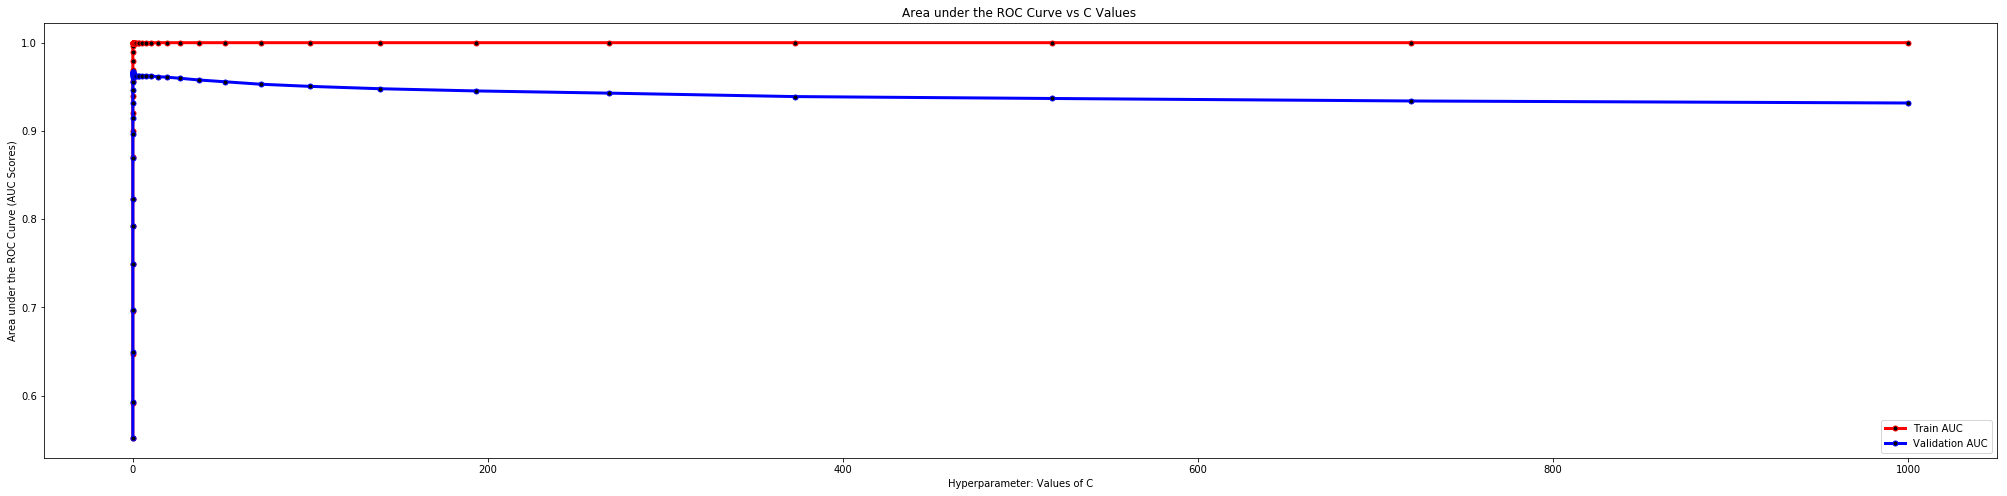

Time taken to complete grid search:  0:11:23.579052

'''PERFORMANCE EVALUATION for TF-IDF model using l1 regularization'''

Detailed report for Logistic regression using l1 regulaization

The number of accurate predictions out of 30000 data points on unseen data for l1 regularization is 28568
Accuracy of the TF-IDF model using l1 regularization on unseen data is 95.22666666666667 %
Precision of the TF-IDF model using l1 regularization on unseen data is 0.9669
Recall of the TF-IDF model using l1 regularization on unseen data is 0.9766
F1 score of the TF-IDF model using l1 regularization on unseen data is 0.9717
AUC of the TF-IDF model using l1 regularization on unseen data is 0.9775

Clasification report 
              precision    recall  f1-score   support

           0       0.87      0.83      0.85      4822
           1       0.97      0.98      0.97     25178

   micro avg       0.95      0.95      0.95     30000
   macro avg       0.92      0.90      0.91     30000
weighted avg  

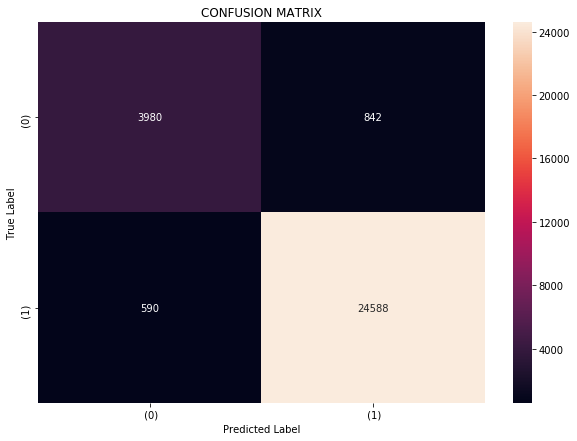

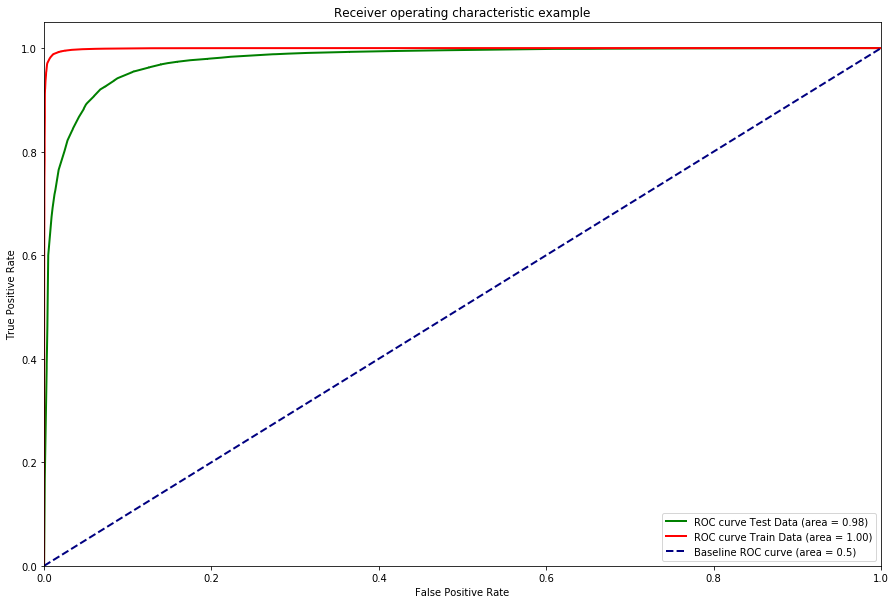

In [37]:
#Load the TF-IDF Vectors we had created earlier and standardize them. We will standardize the traina and test data seperately in order to prevent data leakage.
import pickle

with open('X_train_TFIDF.pkl', 'rb') as file:
    X_train = pickle.load(file)
    
with open('X_test_TFIDF.pkl', 'rb') as file:
    X_test = pickle.load(file)

with open('y_train_TFIDF.pkl', 'rb') as file:
    y_train = pickle.load(file)
    
with open('y_test_TFIDF.pkl', 'rb') as file:
    y_test = pickle.load(file)
    
with open('X_calib_TFIDF.pkl', 'rb') as file:
    X_calib = pickle.load(file)

with open('y_calib_TFIDF.pkl', 'rb') as file:
    y_calib = pickle.load(file)    

print("Shape of the train data matrix: ",X_train.shape)
print("Shape of the test data matrix: ",X_test.shape)
print("Shape of the calibration data matrix: ",X_calib.shape)

X_train=standardize(X_train, False)
X_test=standardize(X_test, False)
X_calib=standardize(X_calib, False)

#Perform Grid Search cross validation to obtain the best value of the hyperparameter.
#Use the best estimator obtained from grid search to train a model and get all the evaluation metrics
#Plot the performance of model both on train data and cross validation data for each hyper parameter
#Display the confusion matrix as well as ROC Curve
trained_classifier_TFIDF_L1 = logistic_regression(X_train, y_train, X_test, y_test, X_calib, y_calib, 'l1', 'TF-IDF')

## Hence with managed to achieve ROC curve of 0.98 on test data using TFIDF.